# Advanced Lane Finding


## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
to do the calibration , we use many images around 20 images

failed to find corners for ./camera_cal\calibration1.jpg
failed to find corners for ./camera_cal\calibration4.jpg
failed to find corners for ./camera_cal\calibration5.jpg
(1280, 720)
(720, 1280)


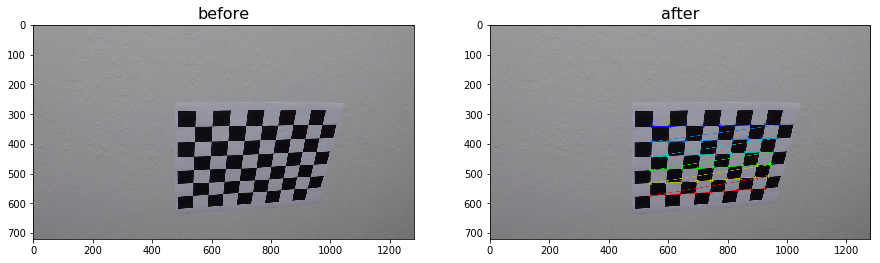

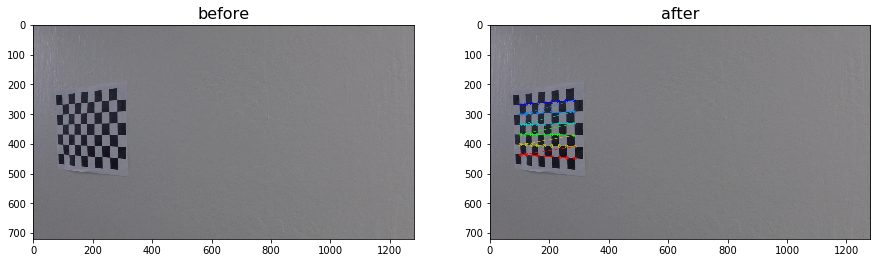

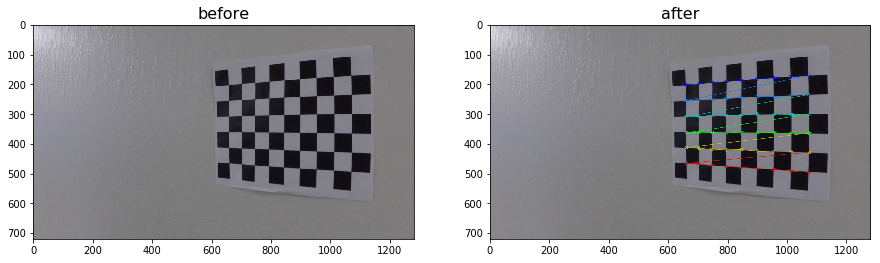

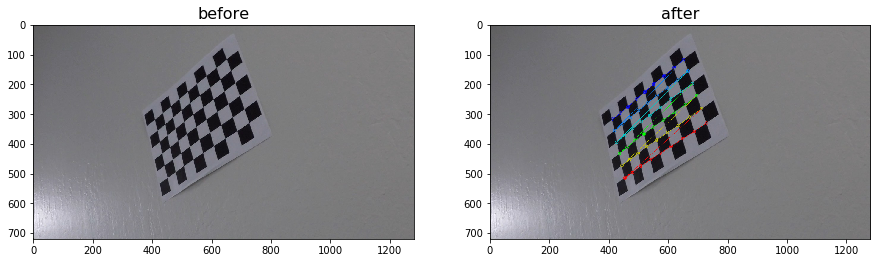

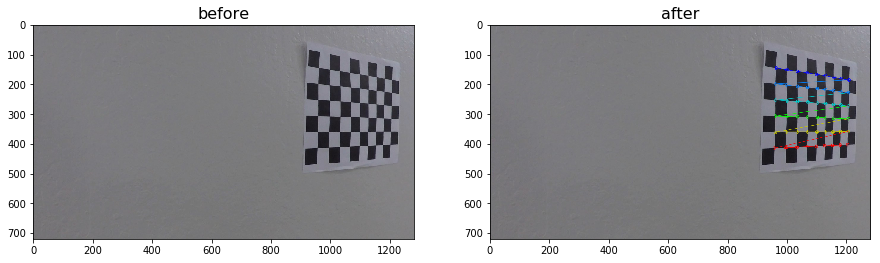

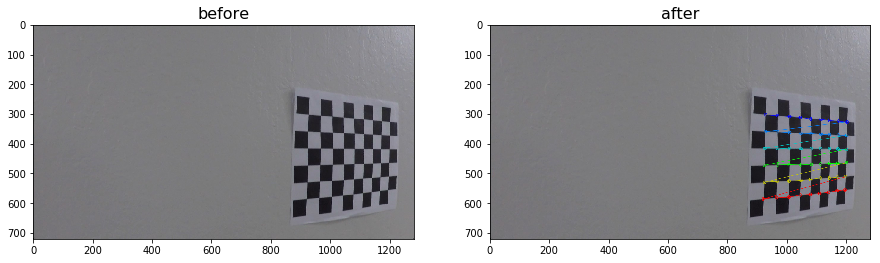

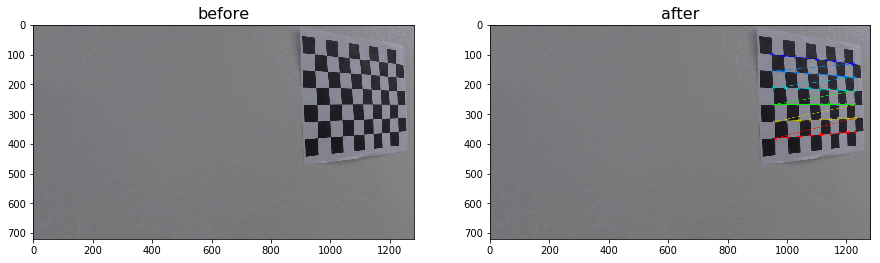

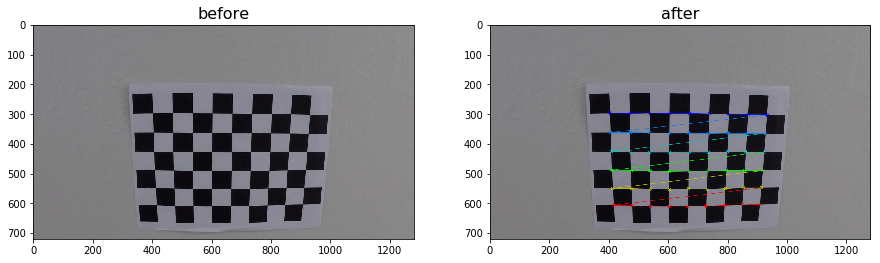

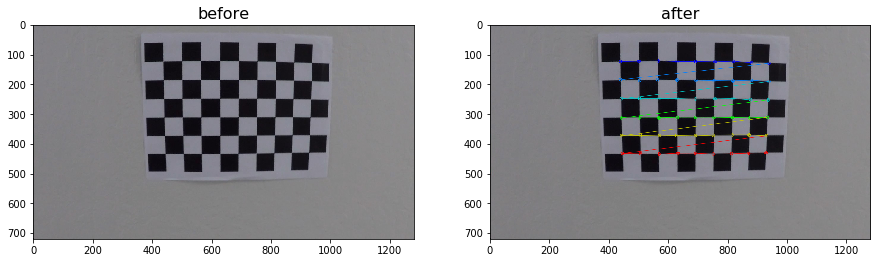

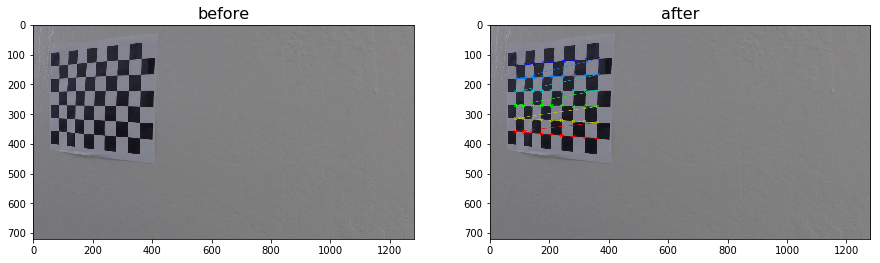

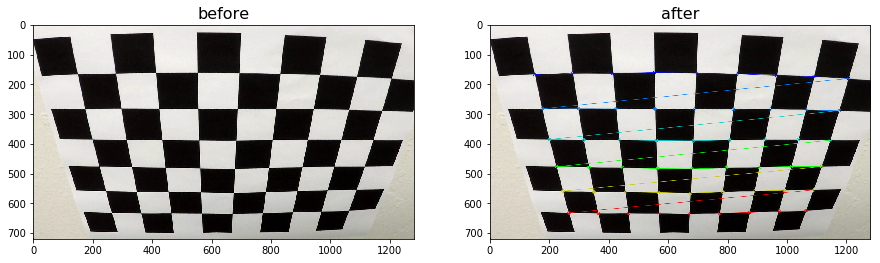

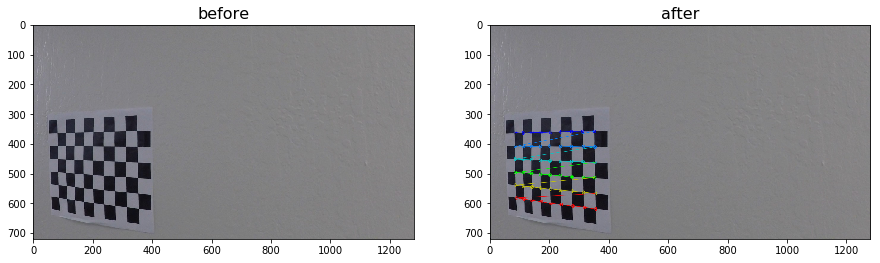

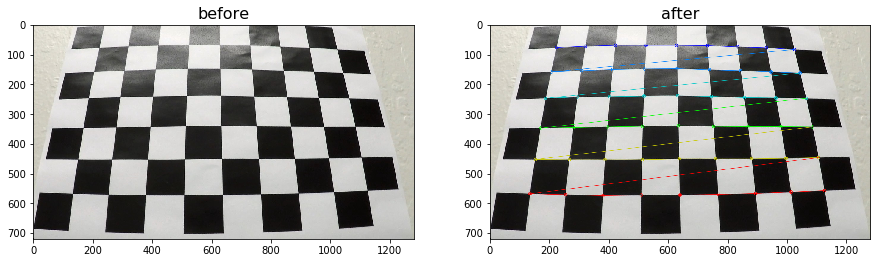

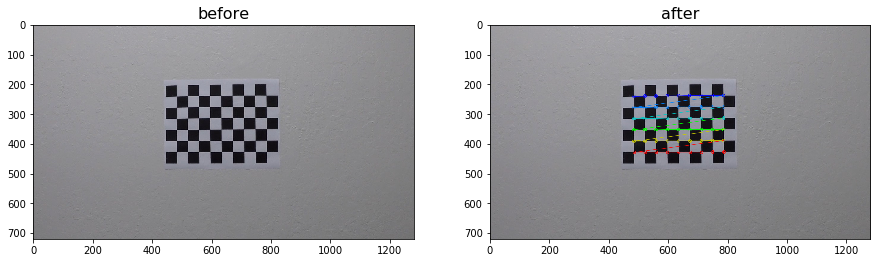

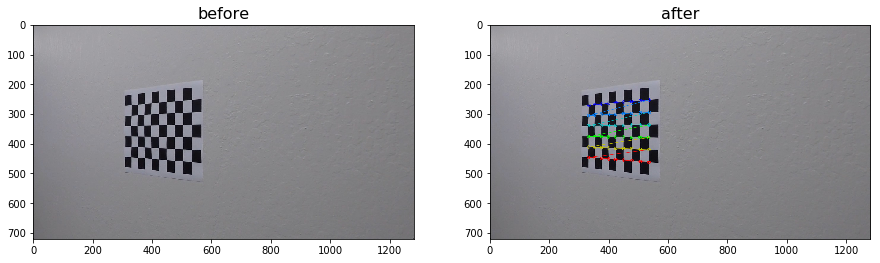

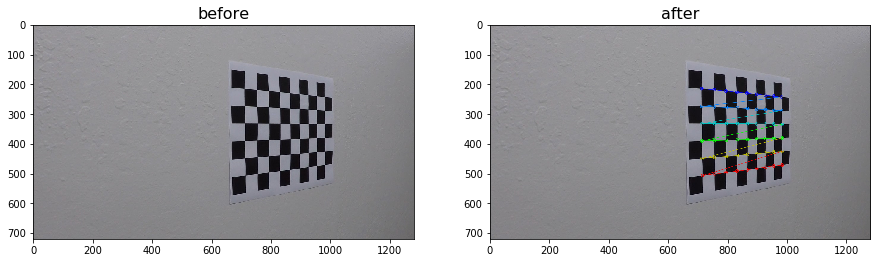

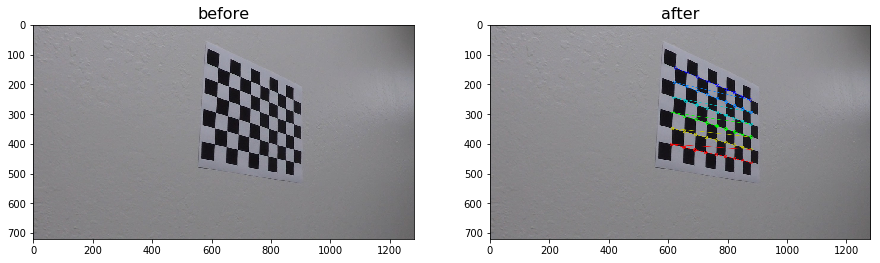

In [2]:
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Make a list of calibration images
image_pathes = glob.glob('./camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []
objp =  np.zeros((6*9,3),np.float32)
objp[:,:2] =  np.mgrid[0:9,0:6].T.reshape(-1,2)

for img_path in image_pathes:
    # Convert to grayscale
    
    img = mpimg.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        #show images
        f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
        axis1.imshow(mpimg.imread(img_path))
        axis1.set_title('before', fontsize=16)
        axis2.imshow(img)
        axis2.set_title('after', fontsize=16)
    else:
        print ("failed to find corners for " + img_path)
print (gray.shape[::-1]) 
print (gray.shape) 
ret,cal_mtx,cal_dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

In [3]:

get_pathes = glob.glob('./test_images/*.jpg')
sample_image = mpimg.imread('./test_images/straight_lines1.jpg')

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    dst = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)   
    return dst

In [5]:
def show_images(image_before, Image_after):
    f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
    axis1.imshow(image_before,cmap='gray')
    axis1.set_title('before', fontsize=16)
    axis2.imshow(Image_after,cmap='gray')
    axis2.set_title('after', fontsize=16)
    
def show_Array_images(image_before):
    i=0
    for img in image_before:
        f, (axis1) = plt.subplots(1, 1, figsize=(15,10))
        axis1.imshow(image_before)
        axis1.set_title(++i, fontsize=16)
    


Gradient / Sobel dx , dy

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 50)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = (cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = (cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresholds(img, HLS_s_threshold=(90, 255), HLS_h_threshold=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > HLS_s_threshold[0]) & (s_channel <= HLS_s_threshold[1])] = 1
    
    h_channel = hls[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > HLS_h_threshold[0]) & (h_channel <= HLS_h_threshold[1])] = 1
    
    img_binary = np.zeros_like(s_channel)
    img_binary[(s_binary == 1) & (h_binary==1)] =1 
    return img_binary

def wrap(img):
    return
    


Step 2: Perspective Transform

In [7]:
def birds_eye(img, display=True, read = True):
    img_size = (img.shape[1], img.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(img,cmap='gray')
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        return warped , Minv
    else:
        return warped , Minv

## Historgarm

In [8]:
def get_histogram(img,splot='n'):
    histogram = np.sum(birds[img.shape[0]//2:,:], axis=0)
    if splot == 'y':
        plt.plot(histogram) 
        return(histogram)
    else:
        return(histogram)

## Sliding Window

In [9]:
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = get_histogram(binary_warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
        # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return (result,ploty,left_fitx,right_fitx,left_fit,right_fit,leftx_base,rightx_base)



## Curvature

In [10]:
def get_curv(ploty,leftx,rightx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad ,right_curverad )

# Warp the detected lane boundaries back onto the original image.


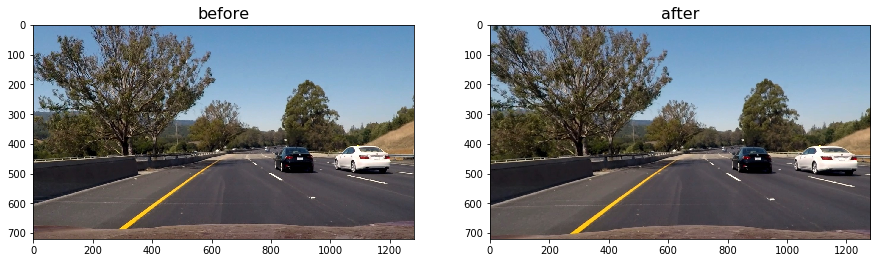

In [11]:
newimages=[]
for img_path in get_pathes:
    sample_image = mpimg.imread(img_path)
    undistorted = cal_undistort(sample_image, objpoints, imgpoints)
    newimages.append(undistorted)
show_images(sample_image,undistorted)

In [12]:
def applyAndPack(images, action):
    """
    Images is a colletion of pairs (`title`, image). This function applies `action` to the image part of `images`
    and pack the pair again to form (`title`, `action`(image)).
    """
    return list(map(lambda img: (img[0], action(img[1])), images))

def applyAndShow(images, action):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = applyAndPack(images, action)
    showImages( output, 2, 3, (15, 13), cmap='gray')
    return output
    
useSChannel = lambda img: undistortAndHLS(img)[:,:,2]

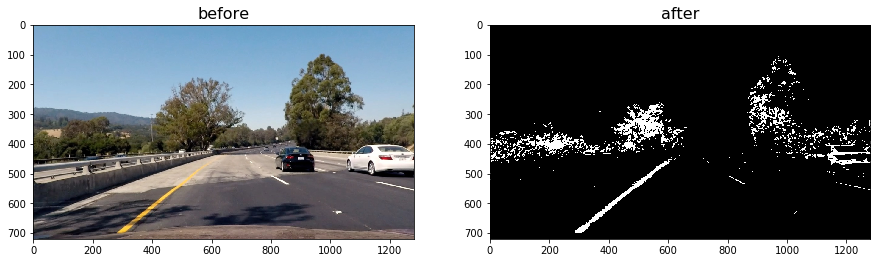

In [13]:
image = newimages[5]
color = color_thresholds(image,HLS_s_threshold=(90, 255))
show_images(image,color)
   



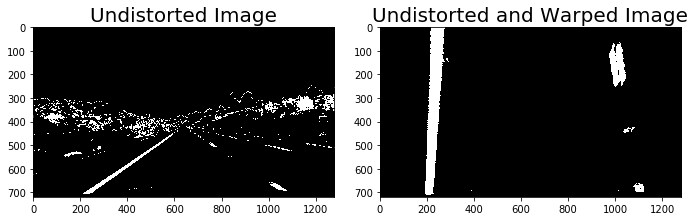

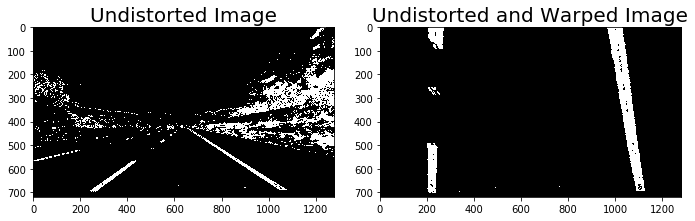

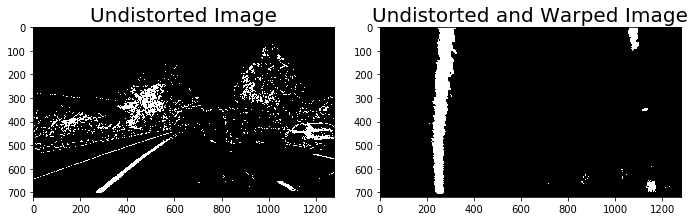

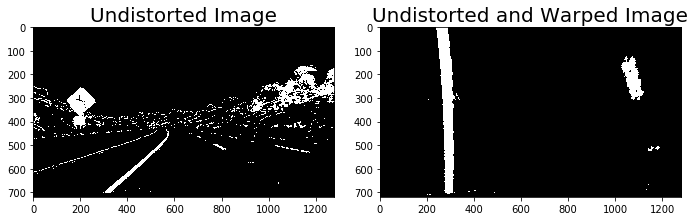

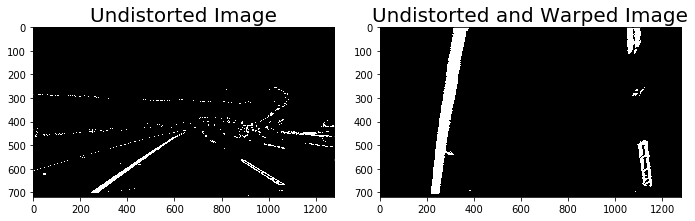

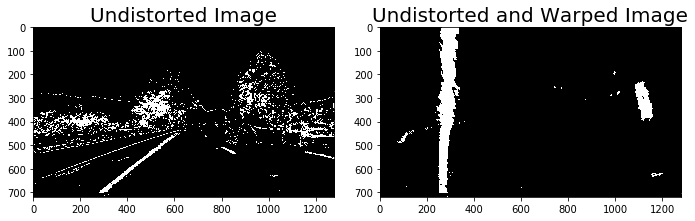

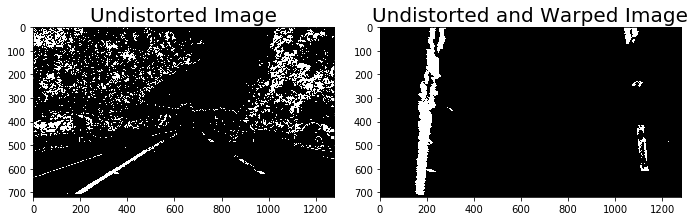

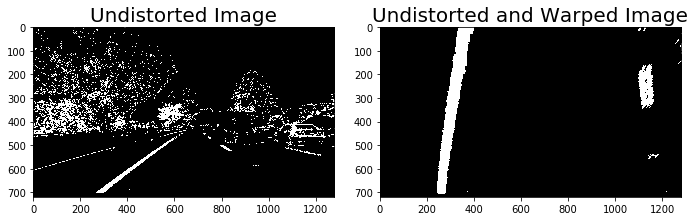

In [14]:
bird_views=[]
for image in newimages:

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(15, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(35, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(60, 255))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.1))
    color = color_thresholds(image)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    combined = np.zeros_like(img)

    combined[(gradx == 1) & (grady == 1) & (mag_binary == 1) | (color == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    birds,M = birds_eye(combined, display=True)
    
    ### experiment code
    bird_views.append(birds)
    


Detect lane pixels and fit to find the lane boundary.

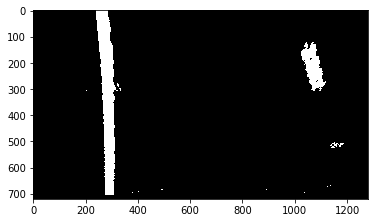

In [15]:
birds = bird_views[3]
historgram =get_histogram(birds)   
plt.imshow(birds, cmap='gray')



1661.73970264 m 2736.55207136 m


(1661.7397026409431, 2736.5520713631154)

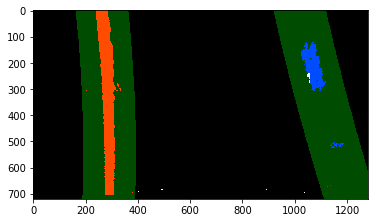

In [16]:
result,ploty, left_fitx, right_fity, left_fit, right_fit,L_b,r_b = sliding_window(birds)
plt.imshow(result)
get_curv(ploty,left_fitx,right_fity)

#### Wrapping

In [17]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [18]:
def pos_center(img_center, leftx_base, rightx_base):
    poly_center = (leftx_base + rightx_base) / 2
    diff_pix = img_center - poly_center
    xm_per_pix = 3.5/1000
    posyapos = diff_pix * xm_per_pix
    return posyapos

In [19]:
def annotate(img, left_curverad, right_curverad, camera):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Left R Curvature: {0:6f} meters'.format(left_curverad), (10,30), font, 2, (255,0,0), 2)
    cv2.putText(img, 'Right R Curvature: {0:6f} meters'.format(right_curverad),(10,80), font, 2, (0,255,0), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(camera), (10,120), font,2, (0,0,255), 2)

In [23]:
def pipline(img):
    img_c = np.copy(img)
    image = cal_undistort(img_c, objpoints, imgpoints)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(15, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(35, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(60, 255))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.1))
    color = color_thresholds(image)
    img_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    combined = np.zeros_like(img_g)

    combined[(gradx == 1) & (grady == 1) & (mag_binary == 1) | (color == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    birds , Minv = birds_eye(combined, display=True)
    
    ### experiment code
    bird_views.append(birds)
     
    result,ploty,left_fitx,right_fitx,left_fit,right_fit,leftx_base,rightx_base= sliding_window(birds)
    left_curverad ,right_curverad  = get_curv(ploty,left_fitx,right_fitx)
    center_pos =  pos_center(img.shape[1]/2,leftx_base,rightx_base)
    annotate(img, left_curverad, right_curverad, center_pos)
    result = draw_lane(img ,birds,left_fit, right_fit, Minv)
    return result

1205.85986117 m 2736.55207136 m


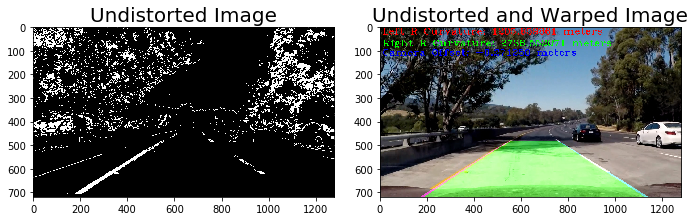

In [21]:
img = mpimg.imread("test_images/test5.jpg")
result = pipline(img)
plt.imshow(result)

    

In [ ]:
from moviepy.editor import VideoFileClip

video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('project_video.mp4').subclip(0,20)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(pipline)
%time processed_video.write_videofile(video_output3, audio=False)

2433.21497769 m 1504.05597269 m
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|                                                                                          | 0/501 [00:00<?, ?it/s]

2433.21497769 m 1504.05597269 m


  0%|▏                                                                                 | 1/501 [00:00<03:24,  2.44it/s]

2176.84932607 m 677.632226834 m


  0%|▎                                                                                 | 2/501 [00:00<03:33,  2.34it/s]

1986.90697418 m 1433.59892726 m


  1%|▍                                                                                 | 3/501 [00:01<03:40,  2.26it/s]

1765.95429966 m 2045.91928054 m


  1%|▋                                                                                 | 4/501 [00:01<03:44,  2.22it/s]

1491.88104016 m 2532.09802832 m


  1%|▊                                                                                 | 5/501 [00:02<03:46,  2.19it/s]

1477.58986644 m 20165.3437745 m


  1%|▉                                                                                 | 6/501 [00:02<03:38,  2.27it/s]

1499.19974251 m 6758.57894859 m


  1%|█▏                                                                                | 7/501 [00:03<03:34,  2.30it/s]

1407.96457398 m 1100.98746572 m


  2%|█▎                                                                                | 8/501 [00:03<03:33,  2.31it/s]

1460.11087689 m 1440.4519877 m


  2%|█▍                                                                                | 9/501 [00:03<03:29,  2.34it/s]

1466.24208895 m 1160.85209466 m


  2%|█▌                                                                               | 10/501 [00:04<03:29,  2.35it/s]

1365.6939059 m 2516.53959977 m


  2%|█▊                                                                               | 11/501 [00:08<05:59,  1.36it/s]

1470.47525624 m 1903.83068241 m


  2%|█▉                                                                               | 12/501 [00:08<05:46,  1.41it/s]

1519.17548615 m 785.150920858 m


  3%|██                                                                               | 13/501 [00:08<05:35,  1.45it/s]

1586.42424282 m 670.22204682 m


  3%|██▎                                                                              | 14/501 [00:09<05:24,  1.50it/s]

1565.37540365 m 1078.87392065 m


  3%|██▍                                                                              | 15/501 [00:09<05:15,  1.54it/s]

1343.75548268 m 1893.688161 m


  3%|██▌                                                                              | 16/501 [00:10<05:07,  1.58it/s]

1279.91582838 m 4181.91015226 m


  3%|██▋                                                                              | 17/501 [00:10<04:59,  1.62it/s]

1303.1632141 m 3485.74728234 m


  4%|██▉                                                                              | 18/501 [00:10<04:52,  1.65it/s]

1371.62717275 m 2041.89024208 m


  4%|███                                                                              | 19/501 [00:11<04:46,  1.68it/s]

1585.1833162 m 1937.19720442 m


  4%|███▏                                                                             | 20/501 [00:11<04:42,  1.70it/s]

1850.50527234 m 1023.28421455 m


  4%|███▍                                                                             | 21/501 [00:16<06:16,  1.28it/s]

2542.1169536 m 839.205319981 m


  4%|███▌                                                                             | 22/501 [00:16<06:06,  1.31it/s]

3209.03832567 m 2026.91925921 m


  5%|███▋                                                                             | 23/501 [00:17<05:59,  1.33it/s]

3845.29471795 m 2633.03173654 m


  5%|███▉                                                                             | 24/501 [00:17<05:51,  1.36it/s]

4494.03226292 m 4908.64101909 m


  5%|████                                                                             | 25/501 [00:18<05:44,  1.38it/s]

6506.31023731 m 1378.53524368 m


  5%|████▏                                                                            | 26/501 [00:18<05:38,  1.40it/s]

7651.31761892 m 975.071350385 m


  5%|████▎                                                                            | 27/501 [00:18<05:32,  1.42it/s]

8584.99693054 m 831.087215259 m


  6%|████▌                                                                            | 28/501 [00:19<05:27,  1.45it/s]

6928.18630372 m 1571.6427433 m


  6%|████▋                                                                            | 29/501 [00:19<05:21,  1.47it/s]

2919.71660486 m 1679.94727166 m


  6%|████▊                                                                            | 30/501 [00:20<05:19,  1.48it/s]

2131.08509911 m 6366.42276025 m


  6%|█████                                                                            | 31/501 [00:20<05:14,  1.49it/s]

1827.38646071 m 130738.742546 m


  6%|█████▏                                                                           | 32/501 [00:21<05:10,  1.51it/s]

1695.36605433 m 36533.4247883 m


  7%|█████▎                                                                           | 33/501 [00:21<05:06,  1.53it/s]

1487.93170564 m 3062.85425372 m


  7%|█████▍                                                                           | 34/501 [00:22<05:02,  1.55it/s]

1542.81324015 m 1310.95983997 m


  7%|█████▋                                                                           | 35/501 [00:22<04:58,  1.56it/s]

1618.25564834 m 3082.18967911 m


  7%|█████▊                                                                           | 36/501 [00:22<04:56,  1.57it/s]

1570.66001662 m 2970.53566645 m


  7%|█████▉                                                                           | 37/501 [00:23<04:53,  1.58it/s]

1703.72005116 m 1837.60622575 m


  8%|██████▏                                                                          | 38/501 [00:23<04:49,  1.60it/s]

1607.65043976 m 691.594510513 m


  8%|██████▎                                                                          | 39/501 [00:24<04:46,  1.61it/s]

1641.99220856 m 1169.71502379 m


  8%|██████▍                                                                          | 40/501 [00:24<04:43,  1.62it/s]

1698.85034745 m 1472.06535772 m


  8%|██████▋                                                                          | 41/501 [00:25<04:42,  1.63it/s]

1626.61677928 m 1712.79525497 m


  8%|██████▊                                                                          | 42/501 [00:25<04:40,  1.63it/s]

1248.79720138 m 2752.48965259 m


  9%|██████▉                                                                          | 43/501 [00:26<04:38,  1.65it/s]

1200.80839288 m 35407.9733255 m


  9%|███████                                                                          | 44/501 [00:26<04:35,  1.66it/s]

1201.37621872 m 855046.050725 m


  9%|███████▎                                                                         | 45/501 [00:26<04:33,  1.67it/s]

1166.79564978 m 902.865562444 m


  9%|███████▍                                                                         | 46/501 [00:27<04:30,  1.68it/s]

1124.56668267 m 3803.03026627 m


  9%|███████▌                                                                         | 47/501 [00:27<04:28,  1.69it/s]

1114.12061398 m 1283.92071677 m


 10%|███████▊                                                                         | 48/501 [00:28<04:26,  1.70it/s]

1170.16220754 m 2284.55109007 m


 10%|███████▉                                                                         | 49/501 [00:28<04:24,  1.71it/s]

1194.26720001 m 2406.64792898 m


 10%|████████                                                                         | 50/501 [00:29<04:22,  1.72it/s]

1237.24221385 m 2118.42324185 m


 10%|████████▏                                                                        | 51/501 [00:29<04:20,  1.73it/s]

1296.71642237 m 751.775271427 m


 10%|████████▍                                                                        | 52/501 [00:30<04:19,  1.73it/s]

1370.74795053 m 1108.46680079 m


 11%|████████▌                                                                        | 53/501 [00:30<04:17,  1.74it/s]

1437.52966097 m 1543.58087245 m


 11%|████████▋                                                                        | 54/501 [00:30<04:15,  1.75it/s]

1253.69367863 m 1858.25605285 m


 11%|████████▉                                                                        | 55/501 [00:31<04:15,  1.75it/s]

1400.80573722 m 2314.3447493 m


 11%|█████████                                                                        | 56/501 [00:31<04:13,  1.76it/s]

1437.94915134 m 10346.6891487 m


 11%|█████████▏                                                                       | 57/501 [00:32<04:11,  1.77it/s]

1652.95716471 m 26249.1275137 m


 12%|█████████▍                                                                       | 58/501 [00:32<04:09,  1.78it/s]

1991.43815084 m 1903.88988885 m


 12%|█████████▌                                                                       | 59/501 [00:33<04:07,  1.78it/s]

2639.12408567 m 1641.03736374 m


 12%|█████████▋                                                                       | 60/501 [00:33<04:05,  1.79it/s]

4104.87054798 m 2353.62377148 m


 12%|█████████▊                                                                       | 61/501 [00:33<04:04,  1.80it/s]

5210.39936102 m 2787.27352954 m


 12%|██████████                                                                       | 62/501 [00:34<04:03,  1.81it/s]

7209.53597512 m 2075.15073384 m


 13%|██████████▏                                                                      | 63/501 [00:34<04:01,  1.81it/s]

6927.14480994 m 695.381254583 m


 13%|██████████▎                                                                      | 64/501 [00:35<03:59,  1.82it/s]

7161.60227421 m 1150.28896149 m


 13%|██████████▌                                                                      | 65/501 [00:35<03:58,  1.83it/s]

5159.41473836 m 1559.32121041 m


 13%|██████████▋                                                                      | 66/501 [00:35<03:56,  1.84it/s]

5664.47478919 m 2321.6869592 m


 13%|██████████▊                                                                      | 67/501 [00:36<03:55,  1.84it/s]

2948.3271672 m 8424.00120445 m


 14%|██████████▉                                                                      | 68/501 [00:36<03:54,  1.85it/s]

2071.90802073 m 9456.65415783 m


 14%|███████████▏                                                                     | 69/501 [00:37<03:52,  1.86it/s]

1670.04803971 m 2582.1072645 m


 14%|███████████▎                                                                     | 70/501 [00:37<03:51,  1.86it/s]

1409.53428463 m 586.937336044 m


 14%|███████████▍                                                                     | 71/501 [00:37<03:49,  1.87it/s]

1254.28383761 m 17040.2619081 m


 14%|███████████▋                                                                     | 72/501 [00:38<03:50,  1.86it/s]

1141.07363817 m 8424.56091771 m


 15%|███████████▊                                                                     | 73/501 [00:39<03:49,  1.87it/s]

1204.80573998 m 10842.0347203 m


 15%|███████████▉                                                                     | 74/501 [00:39<03:48,  1.87it/s]

1201.75408152 m 7355.68393102 m


 15%|████████████▏                                                                    | 75/501 [00:39<03:46,  1.88it/s]

1291.78045484 m 2049.85519858 m


 15%|████████████▎                                                                    | 76/501 [00:40<03:45,  1.89it/s]

1538.71691212 m 934.276949313 m


 15%|████████████▍                                                                    | 77/501 [00:40<03:44,  1.89it/s]

1906.17053175 m 876.458151105 m


 16%|████████████▌                                                                    | 78/501 [00:41<03:42,  1.90it/s]

3292.32991697 m 1859.65010829 m


 16%|████████████▊                                                                    | 79/501 [00:41<03:41,  1.90it/s]

4090.64096046 m 1903.97625329 m


 16%|████████████▉                                                                    | 80/501 [00:41<03:40,  1.91it/s]

5732.65543741 m 3028.02484824 m


 16%|█████████████                                                                    | 81/501 [00:42<03:39,  1.91it/s]

6349.32294818 m 4412.80481674 m


 16%|█████████████▎                                                                   | 82/501 [00:42<03:38,  1.92it/s]

7922.07748854 m 7371.40815366 m


 17%|█████████████▍                                                                   | 83/501 [00:43<03:37,  1.92it/s]

7324.01994477 m 840.3538432 m


 17%|█████████████▌                                                                   | 84/501 [00:43<03:36,  1.93it/s]

7357.53872538 m 1255.48092857 m


 17%|█████████████▋                                                                   | 85/501 [00:43<03:35,  1.93it/s]

6436.02815172 m 2179.71780881 m


 17%|█████████████▉                                                                   | 86/501 [00:44<03:34,  1.94it/s]

5074.61623968 m 3311.42761265 m


 17%|██████████████                                                                   | 87/501 [00:44<03:33,  1.94it/s]

5648.1765551 m 1217.57533035 m


 18%|██████████████▏                                                                  | 88/501 [00:45<03:32,  1.95it/s]

4813.18605557 m 536.954137122 m


 18%|██████████████▍                                                                  | 89/501 [00:45<03:30,  1.95it/s]

3466.28790051 m 840.6675935 m


 18%|██████████████▌                                                                  | 90/501 [00:46<03:30,  1.96it/s]

3624.45385023 m 1326.15371523 m


 18%|██████████████▋                                                                  | 91/501 [00:46<03:29,  1.96it/s]

4229.85872769 m 1560.08478099 m


 18%|██████████████▊                                                                  | 92/501 [00:47<03:29,  1.95it/s]

2553.67003047 m 21441.0830485 m


 19%|███████████████                                                                  | 93/501 [00:47<03:28,  1.95it/s]

2087.546196 m 2503.44903745 m


 19%|███████████████▏                                                                 | 94/501 [00:48<03:27,  1.96it/s]

1822.66598272 m 1998.85935082 m


 19%|███████████████▎                                                                 | 95/501 [00:48<03:26,  1.96it/s]

1637.82301207 m 470.552109626 m


 19%|███████████████▌                                                                 | 96/501 [00:48<03:25,  1.97it/s]

1500.99934925 m 4635.18038045 m


 19%|███████████████▋                                                                 | 97/501 [00:49<03:24,  1.97it/s]

1519.85079794 m 3237.1528291 m


 20%|███████████████▊                                                                 | 98/501 [00:49<03:24,  1.98it/s]

1445.69057087 m 7596.65316826 m


 20%|████████████████                                                                 | 99/501 [00:50<03:23,  1.98it/s]

1576.33527731 m 17151.1350245 m


 20%|███████████████▉                                                                | 100/501 [00:50<03:22,  1.98it/s]

1680.88055421 m 1333.24736908 m


 20%|████████████████▏                                                               | 101/501 [00:50<03:21,  1.99it/s]

1748.76713575 m 669.742262128 m


 20%|████████████████▎                                                               | 102/501 [00:51<03:20,  1.99it/s]

1929.01610462 m 967.643596901 m


 21%|████████████████▍                                                               | 103/501 [00:51<03:19,  2.00it/s]

2404.10753323 m 1240.06595224 m


 21%|████████████████▌                                                               | 104/501 [00:51<03:18,  2.00it/s]

2801.95409864 m 1215.77003291 m


 21%|████████████████▊                                                               | 105/501 [00:52<03:17,  2.00it/s]

2188.8538478 m 1717.96284259 m


 21%|████████████████▉                                                               | 106/501 [00:52<03:16,  2.01it/s]

2254.51680377 m 12275.9200628 m


 21%|█████████████████                                                               | 107/501 [00:53<03:15,  2.01it/s]

2009.3074744 m 26510.8387079 m


 22%|█████████████████▏                                                              | 108/501 [00:53<03:14,  2.02it/s]

1804.90219099 m 1805.28175462 m


 22%|█████████████████▍                                                              | 109/501 [00:53<03:14,  2.02it/s]

1837.17524637 m 4362.77567623 m


 22%|█████████████████▌                                                              | 110/501 [00:54<03:13,  2.02it/s]

1885.33648531 m 1487.1670073 m


 22%|█████████████████▋                                                              | 111/501 [00:54<03:12,  2.03it/s]

1754.96981886 m 4046.90874206 m


 22%|█████████████████▉                                                              | 112/501 [00:55<03:11,  2.03it/s]

1876.13973726 m 3805.13154198 m


 23%|██████████████████                                                              | 113/501 [00:55<03:10,  2.03it/s]

2032.43861797 m 10028.3071063 m


 23%|██████████████████▏                                                             | 114/501 [00:55<03:09,  2.04it/s]

1784.07397525 m 935.585337464 m


 23%|██████████████████▎                                                             | 115/501 [00:56<03:09,  2.04it/s]

1701.70667274 m 1435.63220204 m


 23%|██████████████████▌                                                             | 116/501 [00:56<03:08,  2.04it/s]

2027.39171048 m 2144.7867747 m


 23%|██████████████████▋                                                             | 117/501 [00:57<03:07,  2.05it/s]

1662.30117994 m 3206.77432025 m


 24%|██████████████████▊                                                             | 118/501 [00:58<03:08,  2.03it/s]

1597.80167137 m 106361.972891 m


 24%|███████████████████                                                             | 119/501 [00:58<03:07,  2.04it/s]

1436.8488323 m 17297.6882416 m


 24%|███████████████████▏                                                            | 120/501 [00:58<03:06,  2.04it/s]

1489.1684147 m 3943.99776732 m


 24%|███████████████████▎                                                            | 121/501 [00:59<03:05,  2.04it/s]

1509.61779378 m 816.16979043 m


 24%|███████████████████▍                                                            | 122/501 [00:59<03:05,  2.05it/s]

1337.64795242 m 1753.77993488 m


 25%|███████████████████▋                                                            | 123/501 [01:00<03:04,  2.05it/s]

1345.29445948 m 1556.90795151 m


 25%|███████████████████▊                                                            | 124/501 [01:00<03:03,  2.05it/s]

1405.57237417 m 3179.80460663 m


 25%|███████████████████▉                                                            | 125/501 [01:00<03:02,  2.06it/s]

1462.17442613 m 994.783691993 m


 25%|████████████████████                                                            | 126/501 [01:01<03:02,  2.06it/s]

1485.03530407 m 562.860007773 m


 25%|████████████████████▎                                                           | 127/501 [01:01<03:01,  2.06it/s]

1560.5651193 m 777.109403573 m


 26%|████████████████████▍                                                           | 128/501 [01:02<03:00,  2.06it/s]

1529.27381953 m 1088.18706376 m


 26%|████████████████████▌                                                           | 129/501 [01:02<03:00,  2.07it/s]

1364.13562086 m 1263.81602503 m


 26%|████████████████████▊                                                           | 130/501 [01:02<02:59,  2.07it/s]

1227.55271108 m 2562.3425563 m


 26%|████████████████████▉                                                           | 131/501 [01:03<02:58,  2.07it/s]

1180.83835597 m 3449.93682668 m


 26%|█████████████████████                                                           | 132/501 [01:03<02:58,  2.07it/s]

1187.49006997 m 16323.2656133 m


 27%|█████████████████████▏                                                          | 133/501 [01:04<02:57,  2.08it/s]

1226.51191007 m 7178.32125115 m


 27%|█████████████████████▍                                                          | 134/501 [01:04<02:56,  2.08it/s]

1419.72809707 m 1238.96926836 m


 27%|█████████████████████▌                                                          | 135/501 [01:04<02:55,  2.08it/s]

1572.31119701 m 2077.72774318 m


 27%|█████████████████████▋                                                          | 136/501 [01:05<02:55,  2.09it/s]

1623.66468087 m 2411.09756804 m


 27%|█████████████████████▉                                                          | 137/501 [01:05<02:54,  2.09it/s]

1940.96767026 m 2308.74391017 m


 28%|██████████████████████                                                          | 138/501 [01:05<02:53,  2.09it/s]

2060.96040404 m 4390.44941848 m


 28%|██████████████████████▏                                                         | 139/501 [01:06<02:52,  2.09it/s]

2692.09607899 m 932.105066485 m


 28%|██████████████████████▎                                                         | 140/501 [01:06<02:52,  2.10it/s]

3218.40789809 m 1056.1250198 m


 28%|██████████████████████▌                                                         | 141/501 [01:07<02:51,  2.10it/s]

2968.42706524 m 1470.72128871 m


 28%|██████████████████████▋                                                         | 142/501 [01:07<02:51,  2.10it/s]

2597.92416937 m 1822.450213 m


 29%|██████████████████████▊                                                         | 143/501 [01:08<02:50,  2.10it/s]

2424.79115862 m 11765.350812 m


 29%|██████████████████████▉                                                         | 144/501 [01:08<02:49,  2.10it/s]

2066.91854408 m 7301.49640515 m


 29%|███████████████████████▏                                                        | 145/501 [01:08<02:49,  2.10it/s]

1734.18042239 m 11506.4240278 m


 29%|███████████████████████▎                                                        | 146/501 [01:09<02:48,  2.11it/s]

1592.19065695 m 1450.10019975 m


 29%|███████████████████████▍                                                        | 147/501 [01:09<02:47,  2.11it/s]

1425.77452305 m 4420.12241017 m


 30%|███████████████████████▋                                                        | 148/501 [01:10<02:48,  2.10it/s]

1397.78003172 m 24917.0607967 m


 30%|███████████████████████▊                                                        | 149/501 [01:11<02:47,  2.10it/s]

1602.50962823 m 8084.04324806 m


 30%|███████████████████████▉                                                        | 150/501 [01:11<02:47,  2.10it/s]

1770.79645683 m 579533.637538 m


 30%|████████████████████████                                                        | 151/501 [01:11<02:46,  2.10it/s]

2223.72904892 m 845.546382046 m


 30%|████████████████████████▎                                                       | 152/501 [01:12<02:46,  2.10it/s]

2450.65044977 m 1859.59854156 m


 31%|████████████████████████▍                                                       | 153/501 [01:12<02:45,  2.10it/s]

3491.43201221 m 4408.99189826 m


 31%|████████████████████████▌                                                       | 154/501 [01:13<02:44,  2.11it/s]

3296.55418833 m 3115.95635647 m


 31%|████████████████████████▊                                                       | 155/501 [01:13<02:44,  2.11it/s]

3586.4906537 m 5591.39220036 m


 31%|████████████████████████▉                                                       | 156/501 [01:13<02:43,  2.11it/s]

3985.72994275 m 12233.6791261 m


 31%|█████████████████████████                                                       | 157/501 [01:14<02:42,  2.11it/s]

2988.82024763 m 7523.27123803 m


 32%|█████████████████████████▏                                                      | 158/501 [01:14<02:42,  2.12it/s]

2807.75595129 m 1469.37766502 m


 32%|█████████████████████████▍                                                      | 159/501 [01:15<02:41,  2.12it/s]

2286.45586479 m 1058.41648984 m


 32%|█████████████████████████▌                                                      | 160/501 [01:15<02:40,  2.12it/s]

1989.78123226 m 1481.35863509 m


 32%|█████████████████████████▋                                                      | 161/501 [01:15<02:40,  2.12it/s]

1841.32227374 m 1057.40515656 m


 32%|█████████████████████████▊                                                      | 162/501 [01:16<02:39,  2.13it/s]

1780.61923866 m 1453.8180465 m


 33%|██████████████████████████                                                      | 163/501 [01:16<02:38,  2.13it/s]

1761.08520124 m 1457.55043229 m


 33%|██████████████████████████▏                                                     | 164/501 [01:16<02:38,  2.13it/s]

1858.56140638 m 905.571016105 m


 33%|██████████████████████████▎                                                     | 165/501 [01:17<02:37,  2.13it/s]

1998.40798592 m 1805.13886333 m


 33%|██████████████████████████▌                                                     | 166/501 [01:17<02:37,  2.13it/s]

1796.89175826 m 2618.64891541 m


 33%|██████████████████████████▋                                                     | 167/501 [01:18<02:36,  2.13it/s]

1689.20646109 m 5274.92994413 m


 34%|██████████████████████████▊                                                     | 168/501 [01:18<02:35,  2.14it/s]

1672.40824497 m 3018.32910661 m


 34%|██████████████████████████▉                                                     | 169/501 [01:19<02:35,  2.14it/s]

1658.26264658 m 2161.48192109 m


 34%|███████████████████████████▏                                                    | 170/501 [01:19<02:34,  2.14it/s]

1494.23082514 m 1439.44829128 m


 34%|███████████████████████████▎                                                    | 171/501 [01:19<02:34,  2.14it/s]

1620.00292224 m 829.026436523 m


 34%|███████████████████████████▍                                                    | 172/501 [01:20<02:33,  2.14it/s]

1599.21640172 m 3797.86777463 m


 35%|███████████████████████████▌                                                    | 173/501 [01:20<02:33,  2.14it/s]

1452.97199039 m 8069.54281439 m


 35%|███████████████████████████▊                                                    | 174/501 [01:21<02:32,  2.14it/s]

1680.16874792 m 3426.18876632 m


 35%|███████████████████████████▉                                                    | 175/501 [01:21<02:31,  2.15it/s]

1852.36801975 m 895.34398958 m


 35%|████████████████████████████                                                    | 176/501 [01:21<02:31,  2.15it/s]

1868.34990265 m 652.21191003 m


 35%|████████████████████████████▎                                                   | 177/501 [01:22<02:30,  2.15it/s]

2404.28617963 m 914.839574249 m


 36%|████████████████████████████▍                                                   | 178/501 [01:22<02:30,  2.15it/s]

4757.76593558 m 1246.39360204 m


 36%|████████████████████████████▌                                                   | 179/501 [01:23<02:29,  2.15it/s]

5739.51817199 m 1234.32130613 m


 36%|████████████████████████████▋                                                   | 180/501 [01:23<02:29,  2.15it/s]

12316.3781987 m 1516.77859965 m


 36%|████████████████████████████▉                                                   | 181/501 [01:24<02:28,  2.15it/s]

26267.038759 m 2994.82870337 m


 36%|█████████████████████████████                                                   | 182/501 [01:24<02:27,  2.16it/s]

11297.3396664 m 2540.9957344 m


 37%|█████████████████████████████▏                                                  | 183/501 [01:24<02:27,  2.16it/s]

5430.48504822 m 4033.3110651 m


 37%|█████████████████████████████▍                                                  | 184/501 [01:25<02:26,  2.16it/s]

2865.31735049 m 927.681304408 m


 37%|█████████████████████████████▌                                                  | 185/501 [01:25<02:26,  2.16it/s]

1745.67910264 m 821.524117188 m


 37%|█████████████████████████████▋                                                  | 186/501 [01:26<02:26,  2.14it/s]

1568.78007804 m 876.630993011 m


 37%|█████████████████████████████▊                                                  | 187/501 [01:27<02:26,  2.15it/s]

1201.51083719 m 528.200496697 m


 38%|██████████████████████████████                                                  | 188/501 [01:27<02:25,  2.15it/s]

1110.09192072 m 835.697239713 m


 38%|██████████████████████████████▏                                                 | 189/501 [01:27<02:25,  2.15it/s]

1021.72137945 m 902.684117702 m


 38%|██████████████████████████████▎                                                 | 190/501 [01:28<02:24,  2.15it/s]

1074.99841202 m 1284.22835447 m


 38%|██████████████████████████████▍                                                 | 191/501 [01:28<02:24,  2.15it/s]

1073.59379898 m 1955.93923169 m


 38%|██████████████████████████████▋                                                 | 192/501 [01:29<02:23,  2.15it/s]

1118.94720837 m 7151.8304858 m


 39%|██████████████████████████████▊                                                 | 193/501 [01:29<02:23,  2.15it/s]

1251.03657471 m 5408.021486 m


 39%|██████████████████████████████▉                                                 | 194/501 [01:30<02:22,  2.15it/s]

1305.65277896 m 15139.6353633 m


 39%|███████████████████████████████▏                                                | 195/501 [01:30<02:21,  2.16it/s]

1440.72062268 m 2159.73406723 m


 39%|███████████████████████████████▎                                                | 196/501 [01:30<02:21,  2.16it/s]

1649.63758934 m 3340.4791859 m


 39%|███████████████████████████████▍                                                | 197/501 [01:31<02:20,  2.16it/s]

1616.66717169 m 1661.00704837 m


 40%|███████████████████████████████▌                                                | 198/501 [01:31<02:20,  2.16it/s]

1699.19304681 m 1585.20624993 m


 40%|███████████████████████████████▊                                                | 199/501 [01:31<02:19,  2.16it/s]

1787.16788822 m 3341.75887439 m


 40%|███████████████████████████████▉                                                | 200/501 [01:32<02:19,  2.16it/s]

1881.20100705 m 6893.50502473 m


 40%|████████████████████████████████                                                | 201/501 [01:32<02:18,  2.16it/s]

1571.23676785 m 4715.69260068 m


 40%|████████████████████████████████▎                                               | 202/501 [01:33<02:18,  2.17it/s]

1801.26963297 m 1382.37489481 m


 41%|████████████████████████████████▍                                               | 203/501 [01:33<02:17,  2.17it/s]

1383.52269576 m 2033.20072692 m


 41%|████████████████████████████████▌                                               | 204/501 [01:34<02:16,  2.17it/s]

1507.89047791 m 1860.6023589 m


 41%|████████████████████████████████▋                                               | 205/501 [01:34<02:16,  2.17it/s]

1600.63023296 m 7188.74057637 m


 41%|████████████████████████████████▉                                               | 206/501 [01:34<02:15,  2.17it/s]

1769.13498523 m 16414.1905035 m


 41%|█████████████████████████████████                                               | 207/501 [01:35<02:15,  2.17it/s]

1799.3232047 m 1114.80800958 m


 42%|█████████████████████████████████▏                                              | 208/501 [01:35<02:14,  2.17it/s]

2008.66332576 m 1648.7023567 m


 42%|█████████████████████████████████▎                                              | 209/501 [01:36<02:14,  2.18it/s]

2122.65151354 m 1153.39714103 m


 42%|█████████████████████████████████▌                                              | 210/501 [01:36<02:13,  2.18it/s]

2654.60872939 m 1601.58135436 m


 42%|█████████████████████████████████▋                                              | 211/501 [01:36<02:13,  2.18it/s]

2478.77177367 m 1824.02866473 m


 42%|█████████████████████████████████▊                                              | 212/501 [01:37<02:12,  2.18it/s]

2518.75415657 m 1915.47306022 m


 43%|██████████████████████████████████                                              | 213/501 [01:37<02:12,  2.18it/s]

2129.99273153 m 770.226049063 m


 43%|██████████████████████████████████▏                                             | 214/501 [01:38<02:11,  2.18it/s]

1896.94032244 m 1141.58755655 m


 43%|██████████████████████████████████▎                                             | 215/501 [01:38<02:11,  2.18it/s]

1490.44586878 m 1764.82789487 m


 43%|██████████████████████████████████▍                                             | 216/501 [01:38<02:10,  2.18it/s]

1229.03688287 m 1500.07076962 m


 43%|██████████████████████████████████▋                                             | 217/501 [01:39<02:09,  2.19it/s]

1166.79850089 m 3344.31842466 m


 44%|██████████████████████████████████▊                                             | 218/501 [01:39<02:09,  2.19it/s]

1150.27543916 m 9805.92926939 m


 44%|██████████████████████████████████▉                                             | 219/501 [01:40<02:08,  2.19it/s]

1211.44806587 m 44246.1009697 m


 44%|███████████████████████████████████▏                                            | 220/501 [01:40<02:08,  2.19it/s]

1313.31564729 m 3525.80621471 m


 44%|███████████████████████████████████▎                                            | 221/501 [01:40<02:07,  2.19it/s]

1441.05618898 m 1439.55825008 m


 44%|███████████████████████████████████▍                                            | 222/501 [01:41<02:07,  2.19it/s]

1513.15672581 m 1993.78169475 m


 45%|███████████████████████████████████▌                                            | 223/501 [01:41<02:06,  2.19it/s]

1630.17695568 m 2453.033139 m


 45%|███████████████████████████████████▊                                            | 224/501 [01:42<02:06,  2.19it/s]

1665.85770835 m 9459.14700536 m


 45%|███████████████████████████████████▉                                            | 225/501 [01:42<02:05,  2.19it/s]

1750.87379756 m 1035.83672865 m


 45%|████████████████████████████████████                                            | 226/501 [01:42<02:05,  2.20it/s]

1702.47466742 m 1761.57731526 m


 45%|████████████████████████████████████▏                                           | 227/501 [01:43<02:04,  2.20it/s]

2027.96275834 m 19652.7353894 m


 46%|████████████████████████████████████▍                                           | 228/501 [01:43<02:04,  2.20it/s]

1537.06790342 m 6428.23067159 m


 46%|████████████████████████████████████▌                                           | 229/501 [01:44<02:03,  2.20it/s]

1742.90110045 m 55377.6687964 m


 46%|████████████████████████████████████▋                                           | 230/501 [01:44<02:03,  2.20it/s]

1905.89453383 m 2052.92750281 m


 46%|████████████████████████████████████▉                                           | 231/501 [01:44<02:02,  2.20it/s]

1979.59336339 m 3359.41099019 m


 46%|█████████████████████████████████████                                           | 232/501 [01:45<02:02,  2.20it/s]

2151.35499186 m 978.631573498 m


 47%|█████████████████████████████████████▏                                          | 233/501 [01:46<02:02,  2.19it/s]

2247.32785195 m 4795.48212419 m


 47%|█████████████████████████████████████▎                                          | 234/501 [01:46<02:02,  2.19it/s]

2290.51714969 m 6226.7196496 m


 47%|█████████████████████████████████████▌                                          | 235/501 [01:47<02:01,  2.19it/s]

2030.03793713 m 2876.59760958 m


 47%|█████████████████████████████████████▋                                          | 236/501 [01:47<02:01,  2.19it/s]

2291.62398427 m 19614.1485262 m


 47%|█████████████████████████████████████▊                                          | 237/501 [01:48<02:00,  2.19it/s]

2545.06216152 m 883.507235571 m


 48%|██████████████████████████████████████                                          | 238/501 [01:48<02:00,  2.19it/s]

2951.48069932 m 1110.31285578 m


 48%|██████████████████████████████████████▏                                         | 239/501 [01:49<01:59,  2.19it/s]

3679.84286767 m 1318.68694041 m


 48%|██████████████████████████████████████▎                                         | 240/501 [01:49<01:59,  2.19it/s]

2751.35469976 m 1491.85994313 m


 48%|██████████████████████████████████████▍                                         | 241/501 [01:50<01:58,  2.19it/s]

2692.74220857 m 1930.71800677 m


 48%|██████████████████████████████████████▋                                         | 242/501 [01:50<01:58,  2.19it/s]

2582.22824968 m 8210.85387933 m


 49%|██████████████████████████████████████▊                                         | 243/501 [01:50<01:57,  2.19it/s]

2380.62989946 m 6572.35379751 m


 49%|██████████████████████████████████████▉                                         | 244/501 [01:51<01:57,  2.19it/s]

2130.9853552 m 1113.32078849 m


 49%|███████████████████████████████████████                                         | 245/501 [01:51<01:56,  2.19it/s]

1924.74377188 m 1486.29055109 m


 49%|███████████████████████████████████████▎                                        | 246/501 [01:52<01:56,  2.20it/s]

1961.6838534 m 5151.87640007 m


 49%|███████████████████████████████████████▍                                        | 247/501 [01:52<01:55,  2.20it/s]

1831.01079601 m 2215.02026916 m


 50%|███████████████████████████████████████▌                                        | 248/501 [01:52<01:55,  2.20it/s]

1918.54360267 m 19020.8130366 m


 50%|███████████████████████████████████████▊                                        | 249/501 [01:53<01:54,  2.20it/s]

2135.27300333 m 726.575544264 m


 50%|███████████████████████████████████████▉                                        | 250/501 [01:53<01:54,  2.20it/s]

2385.43555276 m 861.896714331 m


 50%|████████████████████████████████████████                                        | 251/501 [01:54<01:53,  2.20it/s]

2561.31823421 m 1090.4482589 m


 50%|████████████████████████████████████████▏                                       | 252/501 [01:54<01:53,  2.20it/s]

1998.82483875 m 1561.53326948 m


 50%|████████████████████████████████████████▍                                       | 253/501 [01:54<01:52,  2.20it/s]

1818.17590763 m 1526.49701575 m


 51%|████████████████████████████████████████▌                                       | 254/501 [01:55<01:52,  2.20it/s]

1756.29529686 m 9954.39374952 m


 51%|████████████████████████████████████████▋                                       | 255/501 [01:55<01:51,  2.20it/s]

1775.70855618 m 12265.2031486 m


 51%|████████████████████████████████████████▉                                       | 256/501 [01:56<01:51,  2.20it/s]

1652.95928949 m 2868.99577784 m


 51%|█████████████████████████████████████████                                       | 257/501 [01:56<01:50,  2.20it/s]

1709.68060956 m 4090.39235691 m


 51%|█████████████████████████████████████████▏                                      | 258/501 [01:57<01:50,  2.20it/s]

1644.59352696 m 3933.04266606 m


 52%|█████████████████████████████████████████▎                                      | 259/501 [01:57<01:49,  2.21it/s]

1746.55831764 m 2392.51700321 m


 52%|█████████████████████████████████████████▌                                      | 260/501 [01:57<01:49,  2.21it/s]

2209.10021817 m 2545.92897969 m


 52%|█████████████████████████████████████████▋                                      | 261/501 [01:58<01:48,  2.21it/s]

2737.48862829 m 920.030703934 m


 52%|█████████████████████████████████████████▊                                      | 262/501 [01:58<01:48,  2.21it/s]

3351.33153721 m 867.19004607 m


 52%|█████████████████████████████████████████▉                                      | 263/501 [01:58<01:47,  2.21it/s]

4206.0285886 m 1614.08863989 m


 53%|██████████████████████████████████████████▏                                     | 264/501 [01:59<01:47,  2.21it/s]

3019.57228508 m 1955.39294146 m


 53%|██████████████████████████████████████████▎                                     | 265/501 [01:59<01:46,  2.21it/s]

2610.4007734 m 2257.37662379 m


 53%|██████████████████████████████████████████▍                                     | 266/501 [02:00<01:46,  2.21it/s]

2181.39739808 m 8331.89839511 m


 53%|██████████████████████████████████████████▋                                     | 267/501 [02:00<01:45,  2.22it/s]

1914.71129707 m 24946.5310708 m


 53%|██████████████████████████████████████████▊                                     | 268/501 [02:00<01:45,  2.22it/s]

1864.2470117 m 730931.201665 m


 54%|██████████████████████████████████████████▉                                     | 269/501 [02:01<01:44,  2.22it/s]

1925.89139917 m 12599.8398752 m


 54%|███████████████████████████████████████████                                     | 270/501 [02:01<01:44,  2.22it/s]

1696.39729768 m 1268.16986955 m


 54%|███████████████████████████████████████████▎                                    | 271/501 [02:02<01:43,  2.22it/s]

1816.11052925 m 1819.42713307 m


 54%|███████████████████████████████████████████▍                                    | 272/501 [02:02<01:43,  2.22it/s]

2063.16879057 m 1997.71528409 m


 54%|███████████████████████████████████████████▌                                    | 273/501 [02:03<01:42,  2.22it/s]

2083.84587647 m 842.554201356 m


 55%|███████████████████████████████████████████▊                                    | 274/501 [02:03<01:42,  2.22it/s]

2347.38907931 m 1564.68705456 m


 55%|███████████████████████████████████████████▉                                    | 275/501 [02:03<01:41,  2.22it/s]

2523.52599926 m 2655.45132269 m


 55%|████████████████████████████████████████████                                    | 276/501 [02:04<01:41,  2.22it/s]

2117.51606726 m 3337.56751731 m


 55%|████████████████████████████████████████████▏                                   | 277/501 [02:04<01:40,  2.22it/s]

2083.39159334 m 13599.8357063 m


 55%|████████████████████████████████████████████▍                                   | 278/501 [02:05<01:40,  2.22it/s]

1908.25268155 m 3353.85726832 m


 56%|████████████████████████████████████████████▌                                   | 279/501 [02:05<01:39,  2.22it/s]

1927.39693899 m 2628.20694713 m


 56%|████████████████████████████████████████████▋                                   | 280/501 [02:05<01:39,  2.22it/s]

1896.86806515 m 548.84075224 m


 56%|████████████████████████████████████████████▊                                   | 281/501 [02:06<01:38,  2.22it/s]

2060.68135881 m 2188.57057248 m


 56%|█████████████████████████████████████████████                                   | 282/501 [02:06<01:38,  2.23it/s]

2247.5630748 m 1941.97935562 m


 56%|█████████████████████████████████████████████▏                                  | 283/501 [02:07<01:37,  2.23it/s]

2231.53177709 m 4118.36551568 m


 57%|█████████████████████████████████████████████▎                                  | 284/501 [02:07<01:37,  2.23it/s]

2296.61995935 m 2366.47423847 m


 57%|█████████████████████████████████████████████▌                                  | 285/501 [02:07<01:37,  2.23it/s]

2931.91510801 m 15027.6349626 m


 57%|█████████████████████████████████████████████▋                                  | 286/501 [02:08<01:36,  2.23it/s]

3151.49554999 m 1060.44392159 m


 57%|█████████████████████████████████████████████▊                                  | 287/501 [02:08<01:36,  2.23it/s]

3529.35018794 m 2014.41334205 m


 57%|█████████████████████████████████████████████▉                                  | 288/501 [02:09<01:35,  2.23it/s]

2658.67778021 m 3129.66052895 m


 58%|██████████████████████████████████████████████▏                                 | 289/501 [02:09<01:35,  2.23it/s]

2503.35655131 m 12991.9907518 m


 58%|██████████████████████████████████████████████▎                                 | 290/501 [02:11<01:35,  2.21it/s]

2594.21466401 m 2857.24205787 m


 58%|██████████████████████████████████████████████▍                                 | 291/501 [02:11<01:34,  2.21it/s]

2463.16343778 m 2147.34859099 m


 58%|██████████████████████████████████████████████▋                                 | 292/501 [02:12<01:34,  2.21it/s]

2861.11504444 m 935.638061177 m


 58%|██████████████████████████████████████████████▊                                 | 293/501 [02:12<01:34,  2.21it/s]

2826.96437643 m 4193.93366143 m


 59%|██████████████████████████████████████████████▉                                 | 294/501 [02:12<01:33,  2.21it/s]

2825.14420853 m 3559.07742204 m


 59%|███████████████████████████████████████████████                                 | 295/501 [02:13<01:33,  2.21it/s]

3184.05500664 m 8313.58923027 m


 59%|███████████████████████████████████████████████▎                                | 296/501 [02:13<01:32,  2.21it/s]

3777.44174331 m 3532.06275981 m


 59%|███████████████████████████████████████████████▍                                | 297/501 [02:14<01:32,  2.21it/s]

4931.11318065 m 1492.71209523 m


 59%|███████████████████████████████████████████████▌                                | 298/501 [02:14<01:31,  2.22it/s]

6627.93506299 m 1112.64707066 m


 60%|███████████████████████████████████████████████▋                                | 299/501 [02:14<01:31,  2.22it/s]

11555.5910526 m 1869.29382865 m


 60%|███████████████████████████████████████████████▉                                | 300/501 [02:15<01:30,  2.22it/s]

5323.18462953 m 3413.1977944 m


 60%|████████████████████████████████████████████████                                | 301/501 [02:15<01:30,  2.22it/s]

5348.46134249 m 3323.50549825 m


 60%|████████████████████████████████████████████████▏                               | 302/501 [02:16<01:29,  2.22it/s]

4555.32191965 m 4490.97322715 m


 60%|████████████████████████████████████████████████▍                               | 303/501 [02:16<01:29,  2.22it/s]

3572.80675855 m 3490.7037556 m


 61%|████████████████████████████████████████████████▌                               | 304/501 [02:16<01:28,  2.22it/s]

3509.26851516 m 755.511808216 m


 61%|████████████████████████████████████████████████▋                               | 305/501 [02:17<01:28,  2.22it/s]

2967.58342926 m 2125.93716898 m


 61%|████████████████████████████████████████████████▊                               | 306/501 [02:17<01:27,  2.22it/s]

2922.45740427 m 3185.21119242 m


 61%|█████████████████████████████████████████████████                               | 307/501 [02:18<01:27,  2.22it/s]

3353.72010186 m 3337.31519877 m


 61%|█████████████████████████████████████████████████▏                              | 308/501 [02:18<01:26,  2.22it/s]

3394.51005479 m 8350.40859192 m


 62%|█████████████████████████████████████████████████▎                              | 309/501 [02:19<01:26,  2.22it/s]

4917.38211302 m 1063.0891751 m


 62%|█████████████████████████████████████████████████▌                              | 310/501 [02:19<01:25,  2.22it/s]

6782.86388985 m 1361.41805213 m


 62%|█████████████████████████████████████████████████▋                              | 311/501 [02:19<01:25,  2.22it/s]

22020.4765309 m 3391.01590325 m


 62%|█████████████████████████████████████████████████▊                              | 312/501 [02:20<01:25,  2.22it/s]

12889.2827687 m 8695.36021734 m


 62%|█████████████████████████████████████████████████▉                              | 313/501 [02:20<01:24,  2.22it/s]

8768.98030282 m 2307.33333142 m


 63%|██████████████████████████████████████████████████▏                             | 314/501 [02:21<01:24,  2.22it/s]

8159.60386392 m 1623.94451806 m


 63%|██████████████████████████████████████████████████▎                             | 315/501 [02:21<01:23,  2.23it/s]

8251.0700538 m 1595.57484084 m


 63%|██████████████████████████████████████████████████▍                             | 316/501 [02:21<01:23,  2.23it/s]

5700.13952181 m 524.413088509 m


 63%|██████████████████████████████████████████████████▌                             | 317/501 [02:22<01:22,  2.23it/s]

5555.07734203 m 2846.89234458 m


 63%|██████████████████████████████████████████████████▊                             | 318/501 [02:22<01:22,  2.23it/s]

4472.08647813 m 4934.53853515 m


 64%|██████████████████████████████████████████████████▉                             | 319/501 [02:23<01:21,  2.23it/s]

3809.67551986 m 4704.57880966 m


 64%|███████████████████████████████████████████████████                             | 320/501 [02:23<01:21,  2.23it/s]

4939.77430354 m 5497.39541922 m


 64%|███████████████████████████████████████████████████▎                            | 321/501 [02:24<01:20,  2.23it/s]

6703.37307758 m 1213.68840112 m


 64%|███████████████████████████████████████████████████▍                            | 322/501 [02:24<01:20,  2.23it/s]

20553.9466398 m 2019.1073825 m


 64%|███████████████████████████████████████████████████▌                            | 323/501 [02:24<01:19,  2.23it/s]

15139.4825202 m 3992.22465573 m


 65%|███████████████████████████████████████████████████▋                            | 324/501 [02:25<01:19,  2.23it/s]

36028.8372827 m 15242.2261959 m


 65%|███████████████████████████████████████████████████▉                            | 325/501 [02:25<01:18,  2.23it/s]

22802.0177785 m 5836.76665492 m


 65%|████████████████████████████████████████████████████                            | 326/501 [02:26<01:18,  2.23it/s]

25707.3737265 m 1953.35638525 m


 65%|████████████████████████████████████████████████████▏                           | 327/501 [02:26<01:18,  2.23it/s]

65723.9352053 m 2388.33715341 m


 65%|████████████████████████████████████████████████████▍                           | 328/501 [02:27<01:17,  2.23it/s]

121771.921639 m 644.762068296 m


 66%|████████████████████████████████████████████████████▌                           | 329/501 [02:27<01:17,  2.23it/s]

910567.158516 m 2139.69699594 m


 66%|████████████████████████████████████████████████████▋                           | 330/501 [02:27<01:16,  2.23it/s]

16891.6425326 m 11199.1641733 m


 66%|████████████████████████████████████████████████████▊                           | 331/501 [02:28<01:16,  2.23it/s]

41278.7620128 m 13319.6176056 m


 66%|█████████████████████████████████████████████████████                           | 332/501 [02:28<01:15,  2.23it/s]

10909.2046436 m 23448.1996162 m


 66%|█████████████████████████████████████████████████████▏                          | 333/501 [02:29<01:15,  2.23it/s]

10256.6009821 m 946.098211981 m


 67%|█████████████████████████████████████████████████████▎                          | 334/501 [02:29<01:14,  2.23it/s]

8937.30262888 m 1633.23943031 m


 67%|█████████████████████████████████████████████████████▍                          | 335/501 [02:29<01:14,  2.23it/s]

6493.22822444 m 1712.84203617 m


 67%|█████████████████████████████████████████████████████▋                          | 336/501 [02:30<01:13,  2.23it/s]

8790.86043444 m 3908.71089381 m


 67%|█████████████████████████████████████████████████████▊                          | 337/501 [02:30<01:13,  2.24it/s]

10791.2501506 m 26671.9836698 m


 67%|█████████████████████████████████████████████████████▉                          | 338/501 [02:31<01:12,  2.23it/s]

16812.5870367 m 2687.74368418 m


 68%|██████████████████████████████████████████████████████▏                         | 339/501 [02:31<01:12,  2.24it/s]

27973.5694685 m 2232.87043816 m


 68%|██████████████████████████████████████████████████████▎                         | 340/501 [02:32<01:12,  2.24it/s]

6527.52920253 m 1253.57609105 m


 68%|██████████████████████████████████████████████████████▍                         | 341/501 [02:32<01:11,  2.24it/s]

4971.67337874 m 2288.09885712 m


 68%|██████████████████████████████████████████████████████▌                         | 342/501 [02:32<01:11,  2.24it/s]

5289.096067 m 2424.4907229 m


 68%|██████████████████████████████████████████████████████▊                         | 343/501 [02:33<01:10,  2.24it/s]

4523.44483315 m 4613.3162035 m


 69%|██████████████████████████████████████████████████████▉                         | 344/501 [02:33<01:10,  2.24it/s]

5036.06230252 m 7654.24344476 m


 69%|███████████████████████████████████████████████████████                         | 345/501 [02:34<01:09,  2.24it/s]

7174.20796023 m 1765.80339615 m


 69%|███████████████████████████████████████████████████████▏                        | 346/501 [02:34<01:09,  2.24it/s]

12355.4697436 m 1224.09452743 m


 69%|███████████████████████████████████████████████████████▍                        | 347/501 [02:35<01:08,  2.24it/s]

12164.4371475 m 2337.23152544 m


 69%|███████████████████████████████████████████████████████▌                        | 348/501 [02:35<01:08,  2.24it/s]

9025.90284889 m 6355.90861456 m


 70%|███████████████████████████████████████████████████████▋                        | 349/501 [02:35<01:07,  2.24it/s]

5004.34756088 m 11707.4904441 m


 70%|███████████████████████████████████████████████████████▉                        | 350/501 [02:36<01:07,  2.24it/s]

4906.50424826 m 1809.0272693 m


 70%|████████████████████████████████████████████████████████                        | 351/501 [02:36<01:06,  2.24it/s]

5210.74914879 m 1415.02476196 m


 70%|████████████████████████████████████████████████████████▏                       | 352/501 [02:37<01:06,  2.24it/s]

5982.94395676 m 1226.93424659 m


 70%|████████████████████████████████████████████████████████▎                       | 353/501 [02:37<01:06,  2.24it/s]

5370.89064263 m 581.606102725 m


 71%|████████████████████████████████████████████████████████▌                       | 354/501 [02:37<01:05,  2.24it/s]

10532.2945021 m 6097.49259864 m


 71%|████████████████████████████████████████████████████████▋                       | 355/501 [02:38<01:05,  2.24it/s]

20449.6552821 m 2265.59917726 m


 71%|████████████████████████████████████████████████████████▊                       | 356/501 [02:38<01:04,  2.24it/s]

231298.409208 m 3334.90682267 m


 71%|█████████████████████████████████████████████████████████                       | 357/501 [02:39<01:04,  2.24it/s]

18682.6366365 m 11980.9528242 m


 71%|█████████████████████████████████████████████████████████▏                      | 358/501 [02:39<01:03,  2.24it/s]

6338.74699418 m 1166.83335511 m


 72%|█████████████████████████████████████████████████████████▎                      | 359/501 [02:41<01:03,  2.23it/s]

4895.3372841 m 2624.20395181 m


 72%|█████████████████████████████████████████████████████████▍                      | 360/501 [02:41<01:03,  2.23it/s]

3473.428532 m 39456.5122 m


 72%|█████████████████████████████████████████████████████████▋                      | 361/501 [02:42<01:02,  2.23it/s]

2864.10896031 m 4375.03851713 m


 72%|█████████████████████████████████████████████████████████▊                      | 362/501 [02:42<01:02,  2.23it/s]

2620.6676195 m 2176.52793273 m


 72%|█████████████████████████████████████████████████████████▉                      | 363/501 [02:42<01:01,  2.23it/s]

2756.01528645 m 1504.31412307 m


 73%|██████████████████████████████████████████████████████████                      | 364/501 [02:43<01:01,  2.23it/s]

2614.95203367 m 754.522668152 m


 73%|██████████████████████████████████████████████████████████▎                     | 365/501 [02:43<01:01,  2.23it/s]

2984.3206438 m 78515.6088971 m


 73%|██████████████████████████████████████████████████████████▍                     | 366/501 [02:44<01:00,  2.23it/s]

6591.60977739 m 32558.0612359 m


 73%|██████████████████████████████████████████████████████████▌                     | 367/501 [02:44<01:00,  2.23it/s]

394796.330206 m 8809.15512767 m


 73%|██████████████████████████████████████████████████████████▊                     | 368/501 [02:45<00:59,  2.23it/s]